# Анализ убытков развлекательного приложения Procrastinate Pro+

# Описание проекта
Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

# Обзор данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

#Присвоим датасетам переменные
try:
    visits, orders, costs = (
    pd.read_csv('datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('datasets/costs_info_short.csv'),  # траты на рекламу
    )
except:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
    )

#Посмотрим что внутри
print('visits')
display(visits.head())
visits.info()
print('--------------------------------------------------------------------------------')

print('orders')
display(orders.head())
orders.info()
print('--------------------------------------------------------------------------------')

print('costs')
display(costs.head())
costs.info()

visits


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------------------------------------
orders


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
--------------------------------------------------------------------------------
costs


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


## Подготовка данных
Приведем тип данных во всех колонках в соответствие со значениями. Проверим отсутствие дубликатов. 

In [2]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Даты приведены из строк в формат дат.

In [3]:
#Поиск дубликатов
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [4]:
#Поиск пропусков
print(visits.isna().sum())
print(orders.isna().sum())
print(costs.isna().sum())

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
User Id     0
Event Dt    0
Revenue     0
dtype: int64
dt         0
Channel    0
costs      0
dtype: int64


In [5]:
#Приведем названия столбцов к единому формату
visits = visits.rename(columns={
    'User Id':'user_id',
    'Region':'region', 
    'Device':'device', 
    'Channel':'channel', 
    'Session Start':'session_start', 
    'Session End':'session_end'})

orders = orders.rename(columns={'User Id':'user_id',
                                'Event Dt':'event_dt',
                                'Revenue':'revenue'})

costs = costs.rename(columns={'Channel':'channel'})

Пропусков и дубликатов не обнаружено, можно приступать к анализу.

# Подготовка функций

In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel','costs', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    profiles['costs'] = profiles['costs'].fillna(0)

    return profiles


In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 12))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 12))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

##  Создадим пользовательские профили. 
Определим минимальную и максимальную даты привлечения пользователей.

In [14]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head()) 

,user_id,first_ts,channel,device,region,dt,month,payer,costs,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,101.2,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,168.3,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.0,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,16.8,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,6.0,0.230769


In [15]:
print('Минимальная дата привлечени:',profiles['first_ts'].min())
print('Максимальная дата привлечени:',profiles['first_ts'].max())

Минимальная дата привлечени: 2019-05-01 00:00:41
Максимальная дата привлечени: 2019-10-27 23:59:04


## Выясним, из каких стран пользователи приходят в приложение
И на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [16]:
region_table = (profiles
                .groupby('region')
                .agg({'user_id':'count', 'payer':'sum'})
                .sort_values(by='user_id', ascending=False)
               )
region_table['payer_rate'] = region_table['payer'] / region_table['user_id']
display(region_table)

,user_id,payer,payer_rate
region,,,
United States,100002,6902,0.069019
UK,17575,700,0.039829
France,17450,663,0.037994
Germany,14981,616,0.041119


Больше всего пользователей из США. Из остальных стран примерно поровну.
Так же, чаще остальных платят Американцы, почти вдвое.

## Какими устройствами пользуются клиенты
И какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [17]:
device_table = (profiles
                .groupby('device')
                .agg({'user_id':'count', 'payer':'sum'})
                .sort_values(by='user_id', ascending=False)
               )
device_table['payer_rate'] = device_table['payer'] / device_table['user_id']
display(device_table)

,user_id,payer,payer_rate
device,,,
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468
Mac,30042,1912,0.063644


Больше всего пользователей заходят с Айфонов. А доля платящих выше у пользователей Макинтош. 

## Изучим рекламные источники привлечения
И определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [18]:
channel_table = (profiles
                .groupby('channel')
                .agg({'user_id':'count', 'payer':'sum'})
                .sort_values(by='user_id', ascending=False)
                .reset_index()
               )
channel_table['payer_rate'] = channel_table['payer'] / channel_table['user_id']
display(channel_table)

,channel,user_id,payer,payer_rate
0,organic,56439,1160,0.020553
1,FaceBoom,29144,3557,0.122049
2,TipTop,19561,1878,0.096007
3,OppleCreativeMedia,8605,233,0.027077
4,LeapBob,8553,262,0.030633
5,WahooNetBanner,8553,453,0.052964
6,RocketSuperAds,4448,352,0.079137
7,MediaTornado,4364,156,0.035747
8,YRabbit,4312,165,0.038265
9,AdNonSense,3880,440,0.113402


Чаще всего пользователи сами находят приложение. Далее приходят из социальных сетей.
Но органические юзеры наименее платящие, больше всего платящих пользователей привлечено через FaceBoom.

## Промежуточные выводы
Профиль наиболее привлекательного киента: пользователь из США, пользуется iPhone, пришел с FaceBoom.
Профиль нименее привлекательного киента: пользователь из Германии, пользуется компьютером, пришел с OppleCreativeMedia.
Хотя органические юзеры реже всего платят, они не расходуют рекламный бюджет, стоимость их привлечения нулевая. А вот реклама от OppleCreativeMedia по доли платящих пользователей близка к отсутствию рекламы.

# Маркетинг

## Посчитаем общую сумму расходов на маркетинг
Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени. Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [19]:
print('Общая сумма расходов: {:.2f}'.format(costs['costs'].sum()))

Общая сумма расходов: 105497.30


In [20]:
costs_table = (costs
        .pivot_table(index='channel', values='costs', aggfunc='sum')
        .sort_values(by='costs', ascending=False)
        .reset_index()
       )
display(costs_table)

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


Наибольшие расходы на рекламу в TipTop и FaceBoom.

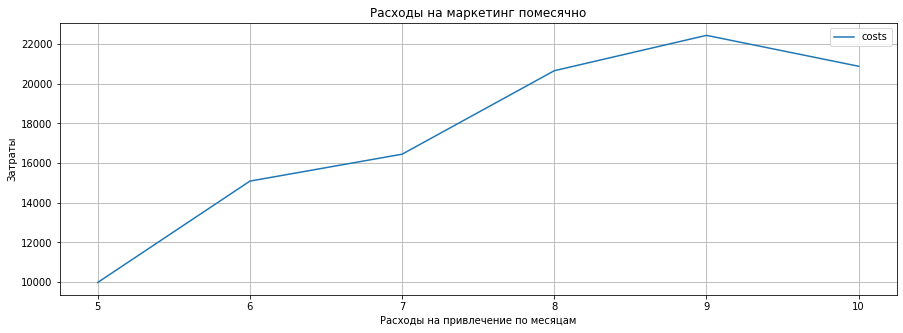

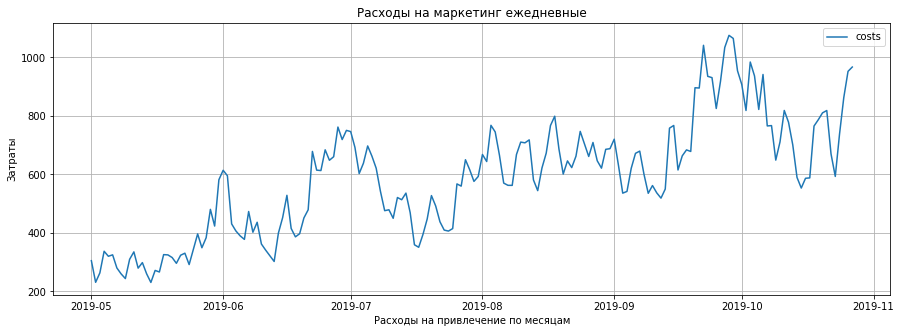

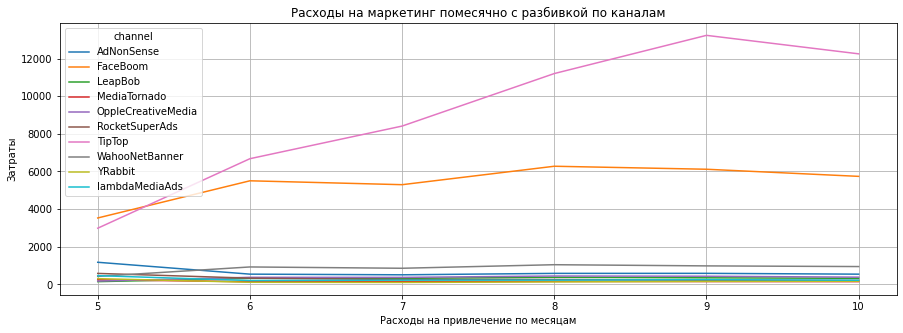

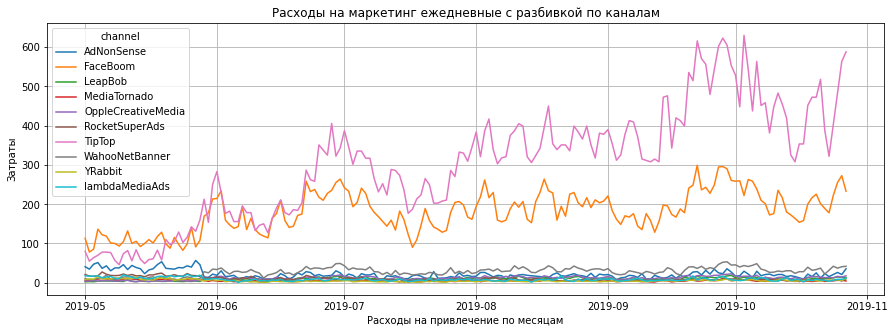

In [21]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month

(
    costs
    .pivot_table(index='month',
                 values='costs',
                 aggfunc='sum')
    .plot(grid=True, 
          figsize=(15,5)))

plt.xlabel('Расходы на привлечение по месяцам')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг помесячно')
plt.show()


(
    costs
    .pivot_table(index='dt',
                 values='costs',
                 aggfunc='sum')
    .plot(grid=True, 
          figsize=(15,5)))

plt.xlabel('Расходы на привлечение по месяцам')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг ежедневные')
plt.show()

(
    costs
    .pivot_table(index='month',
                 columns='channel',
                 values='costs',
                 aggfunc='sum')
    .plot(grid=True, 
          figsize=(15,5)))

plt.xlabel('Расходы на привлечение по месяцам')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг помесячно с разбивкой по каналам')
plt.show()


(
    costs
    .pivot_table(index='dt',
                 columns='channel',
                 values='costs',
                 aggfunc='sum')
    .plot(grid=True, 
          figsize=(15,5)))

plt.xlabel('Расходы на привлечение по месяцам')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг ежедневные с разбивкой по каналам')
plt.show()


Расходы на рекламу растут к началу осени у TipTop. У FaceBoom расходы высокие, но после повышения в начале лета, держатся на одном уровне. У остальных компаний стабильно одинаковые раходы на рекламу.

In [22]:
costs_table = (profiles
               .groupby('channel')
               .agg({'user_id':'count', 'costs':'sum', 'acquisition_cost':'mean'})
               .sort_values(by='costs', ascending=False)
              )

display(costs_table)

,user_id,costs,acquisition_cost
channel,,,
TipTop,19561,6634745.90,2.799003
FaceBoom,29144,5670124.90,1.113286
WahooNetBanner,8553,274956.60,0.602245
OppleCreativeMedia,8605,115732.75,0.250000
AdNonSense,3880,101199.00,1.008054
LeapBob,8553,96408.27,0.210172
RocketSuperAds,4448,50786.71,0.412095
YRabbit,4312,26367.72,0.218975
MediaTornado,4364,25749.84,0.218717


Самые большие затраты на рекламу в TipTop и FaceBoom. Так же, самая большая средняя стоимость привлечения одного клиента у TipTop.

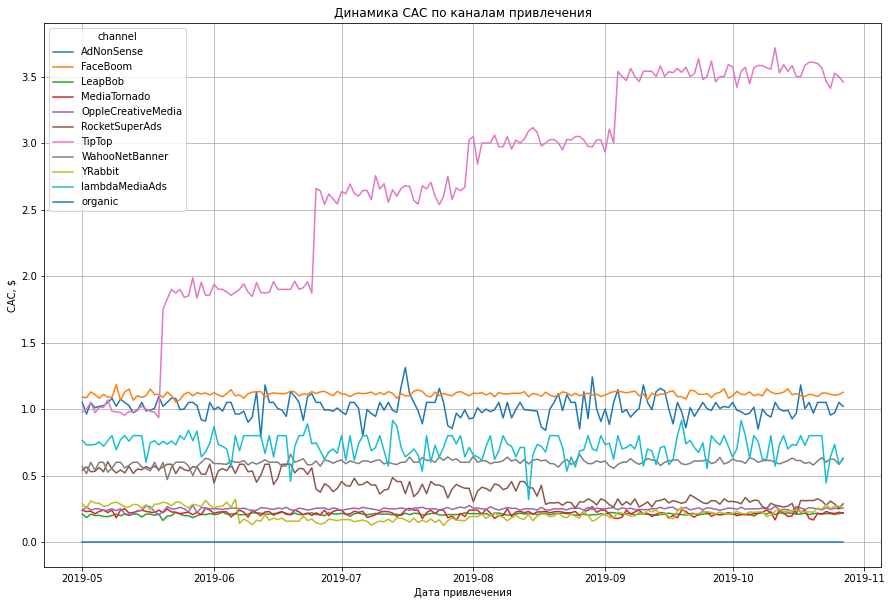

In [23]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

## Промежуточные выводы
Стоимость привлечения «органических» пользователей равна нулю. Привлечение одного пользователя из FaceBoom обошлось компании в среднем в 1 доллар, а из Yrabbit, LeapBob, MediaTornado, OppleCreativeMedia  — примерно в 25 центов.
Стоимость привлечения пользователей из TipTop неуклонно росла с 1 до 3.5 долларов.
TipTop - черная дыра для бюджета.

# Оценка окупаемости рекламы

In [24]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14 #горизонт анализа

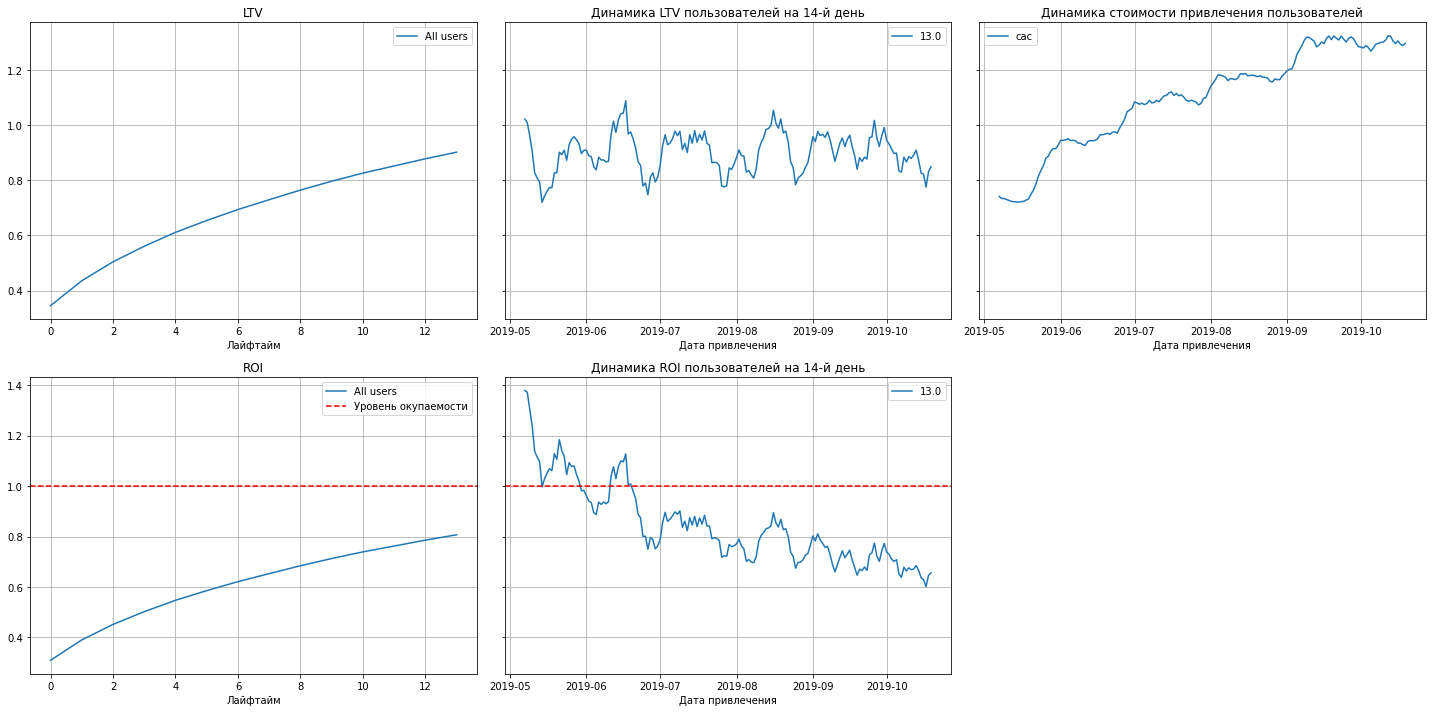

In [25]:
# считаем LTV и ROI
profiles = profiles.query('channel != "organic"')
#за органических пользователей ничего не платим, их в отчете не учитываем

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


По графикам можно сделать такие выводы:
Реклама не окупается. ROI в конце двух недель чуть выше 80%.
CAC растет, возможно дело в увеличении рекламного бюджета.
LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

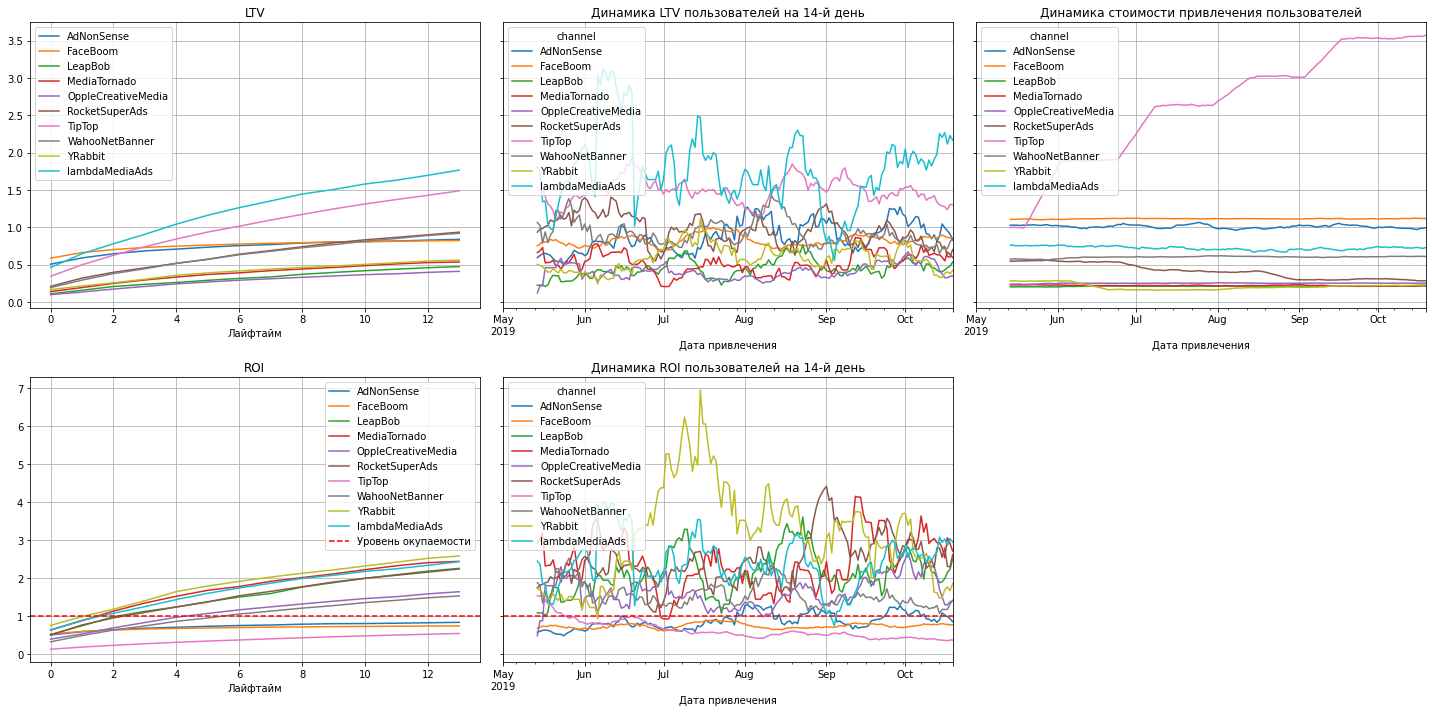

In [26]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи, пришедшие с LambdaMediaAds и TipTop приносят больше всего выручки. Динамика у большинства компаний стабильная, кроме LambdaMediaAds и TipTop. 
Окупаемость большинства рекламных компаний больше единицы, не окупились вложения в TipTop, FaceBoom, AdNonSense.

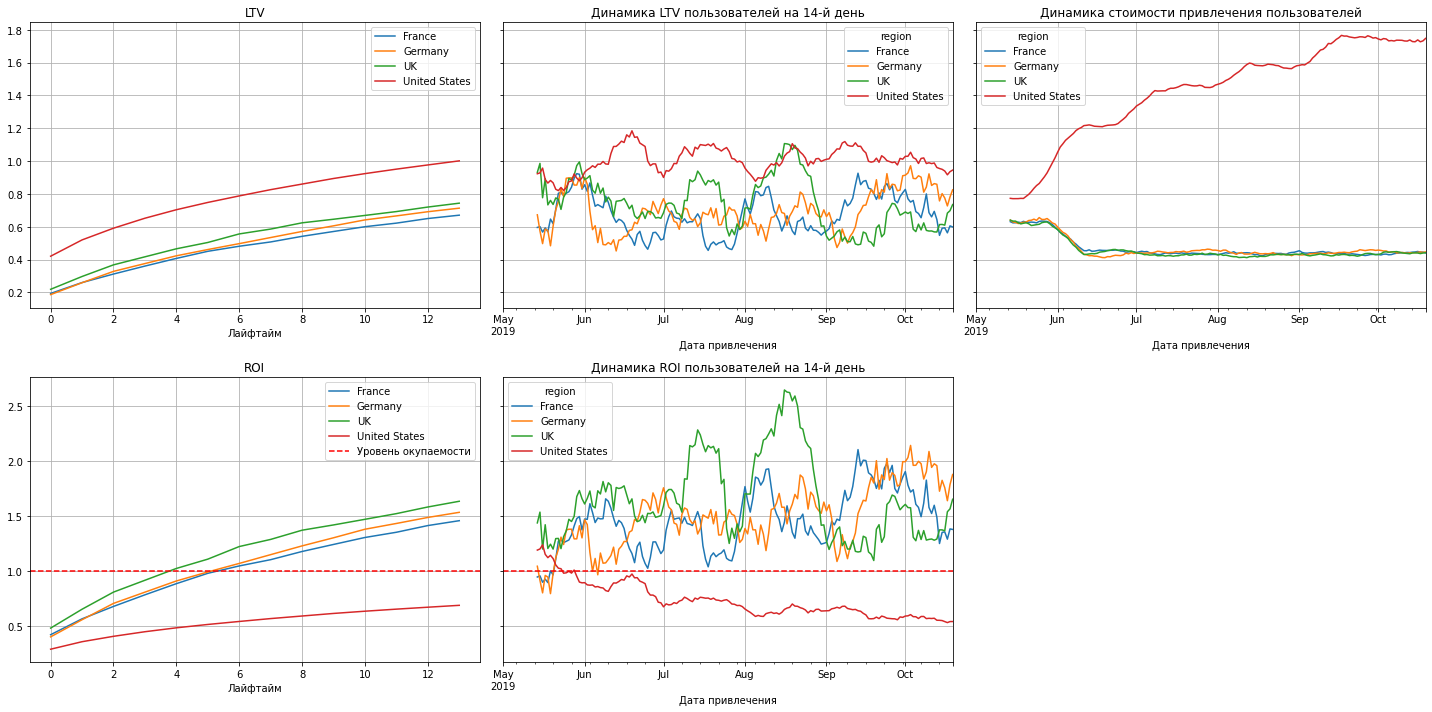

In [27]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:
Видна сезонность, но при этом LTV стабилен.
Больше всего покупок у пользователей из США, меньше всего из Франции.
Реклама не окупается в США. Для этой страны характерна очень высокая стоимость привлечения пользователей.
Для остальных стран стоимость привлечения стабильна и невысока.
Лучше всего окупается Великобритания.

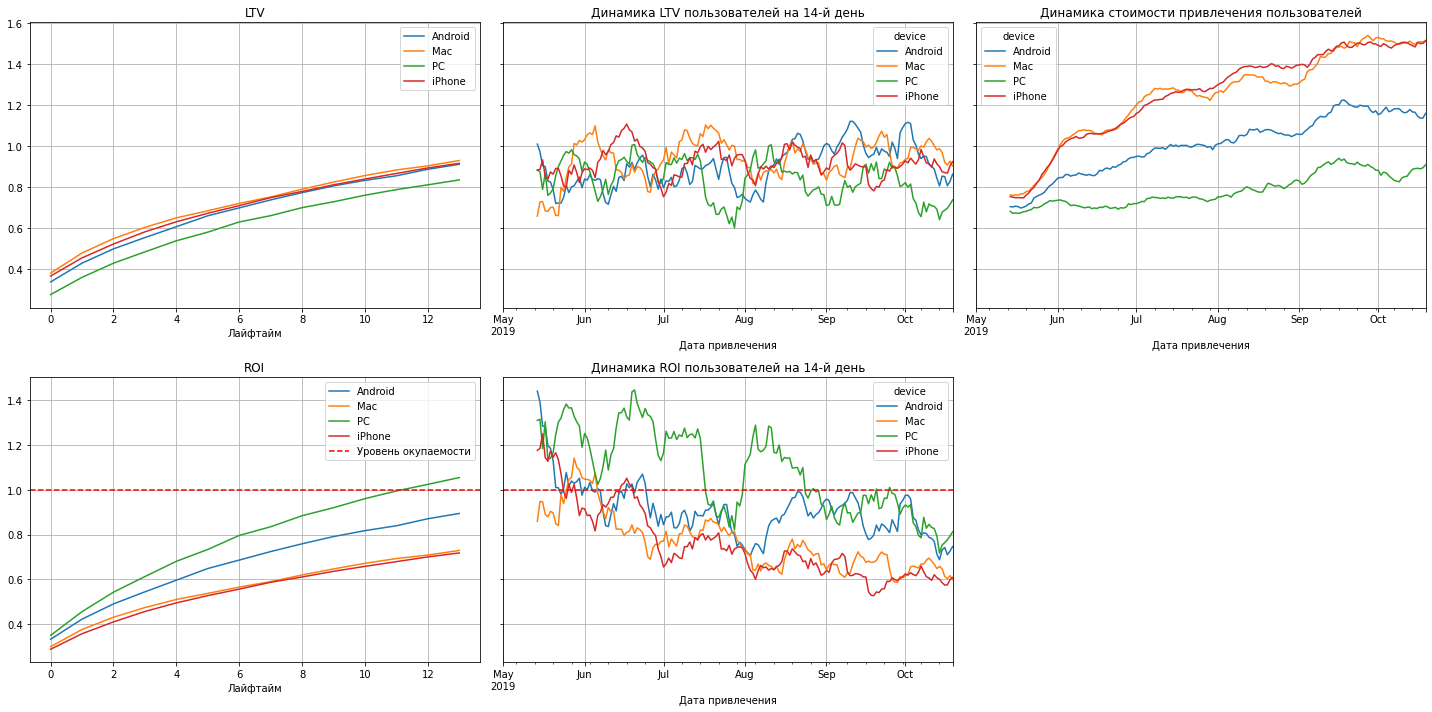

In [28]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Динамика LTV стабильная. 
Стоимость привлечения новых пользователей для пользователей продукции Apple выше остальных и растет, у пользователей ПК относительно стабильная.
Но только пользователи PC окупают свои рекламные вложения.

## Промежуточные выводы
Пользователи, пришедшие с помощью некоторых рекламных компаний (TipTop, LambdaMediaAds) приносят заметно больше денег, но не все из этих компаний окупаются. Очень высокие расходы на рекламу в TipTop не позволяют говорить о целесообразности такой рекламы. Не окупились и вложения в FaceBoom и AdNonSense.
На рекламу в США уходит значительная часть бюджета, сильно больше, чем по другим странам, хоть пользователи из США и оставляют больше денег, но до окупаемости еще очень далеко.
Следует пересмотреть рекламу в США, в частности в TipTop и FaceBoom.

## Построим графики конверсии и удержания
По устройствам, странам, рекламным каналам.

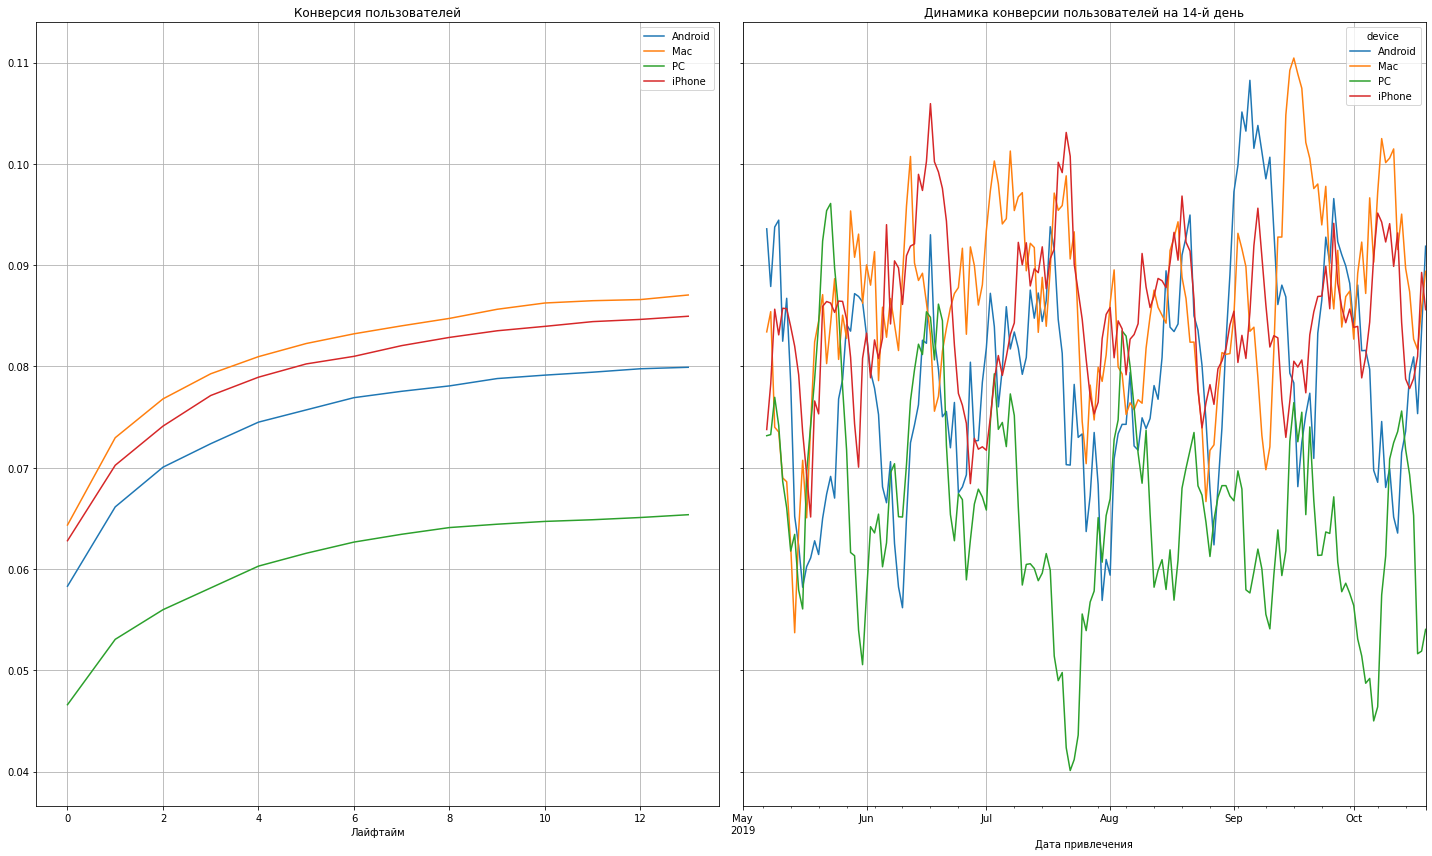

In [29]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи Mac и iPhone конвертируются очень хорошо, причём постоянно, недалеко и Android юзеры.

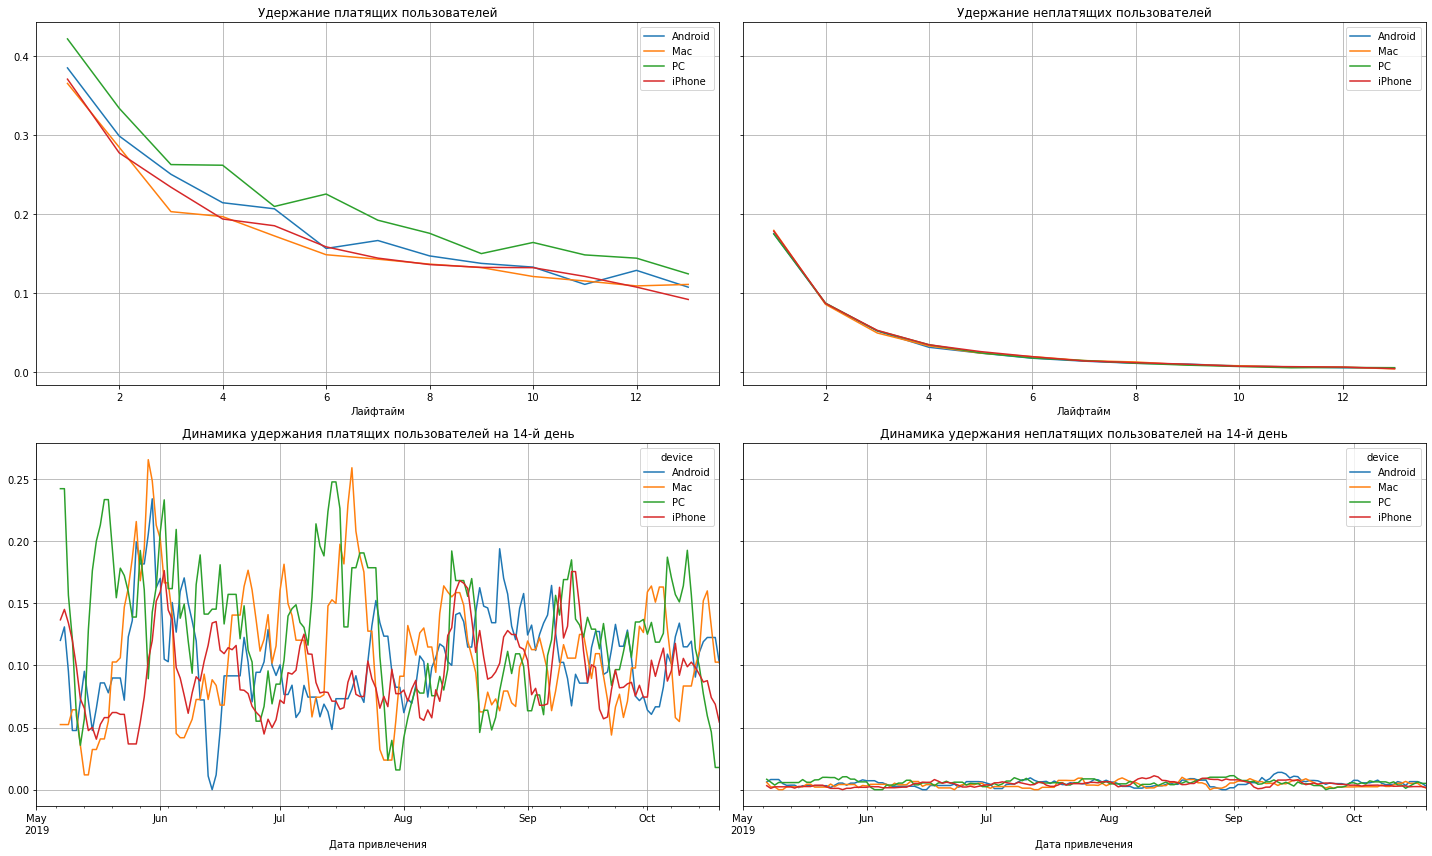

In [30]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание на различных устройствах не сильно отличается.

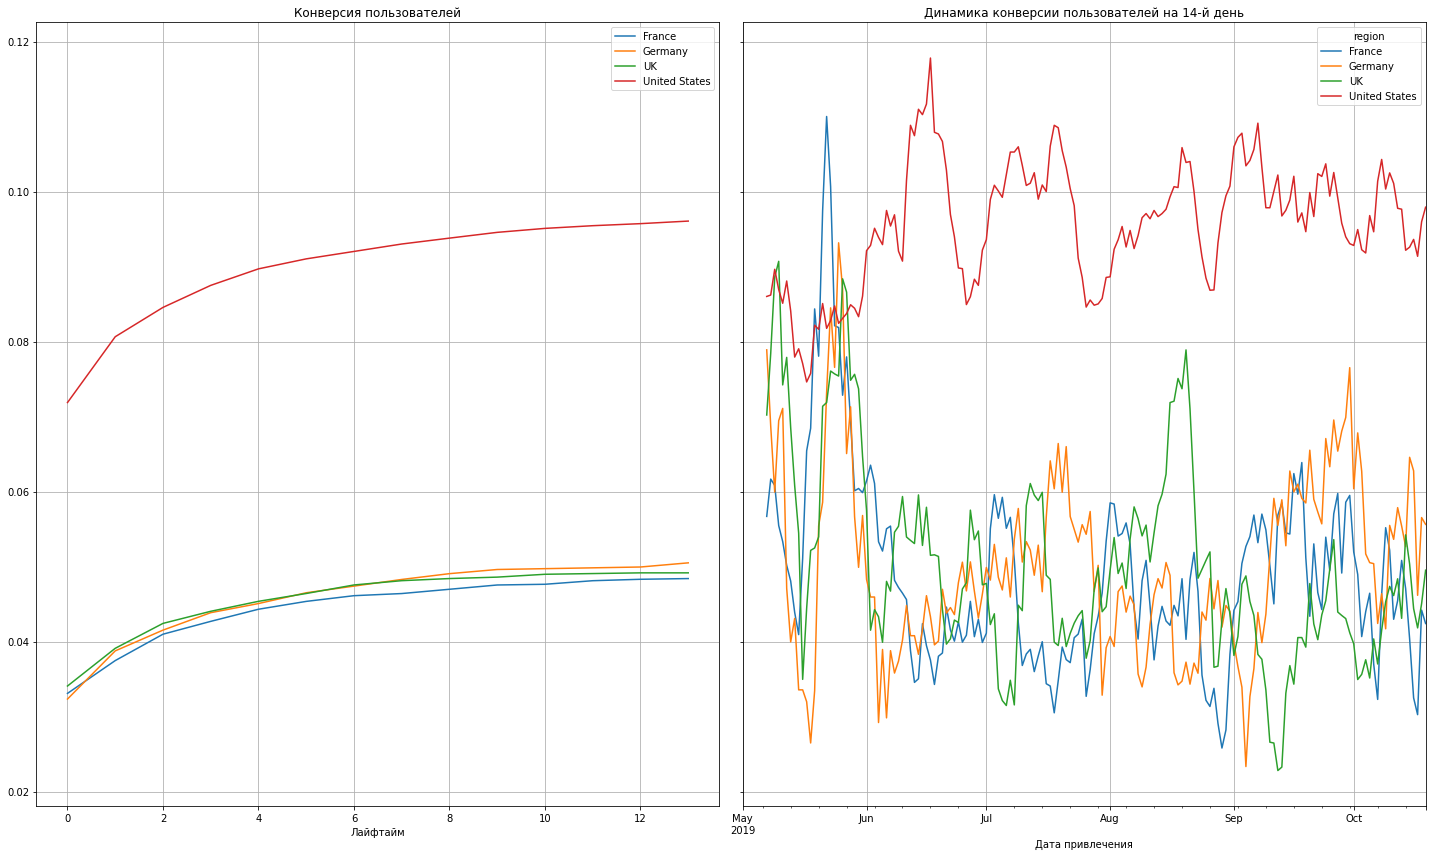

In [31]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия у пользователей из США сильно выше, чем по другим странам.

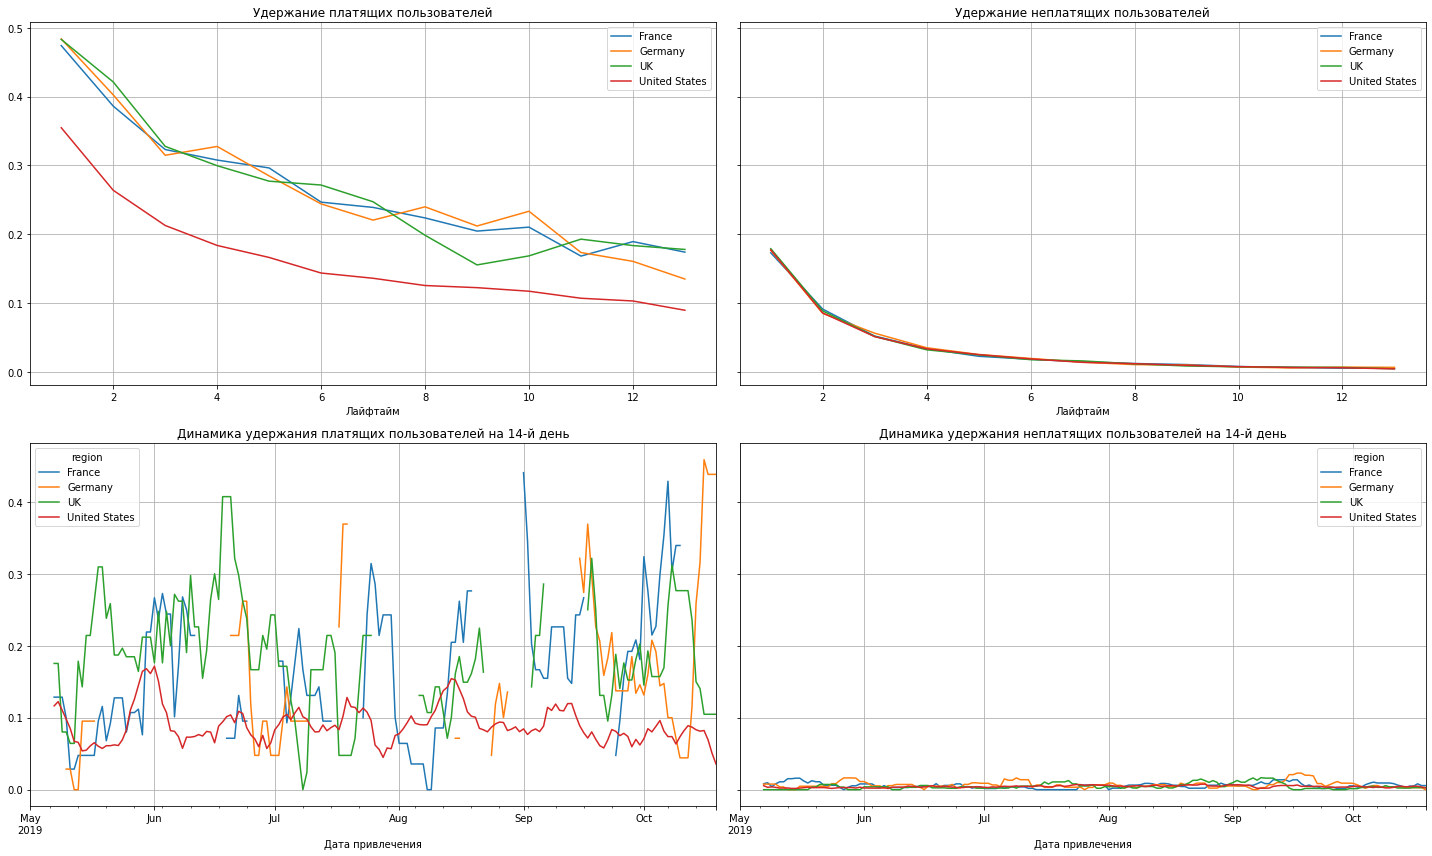

In [32]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот с удержанием у Американцев не все так гладко: оно ниже почти вдвое, чем по европейским странам.

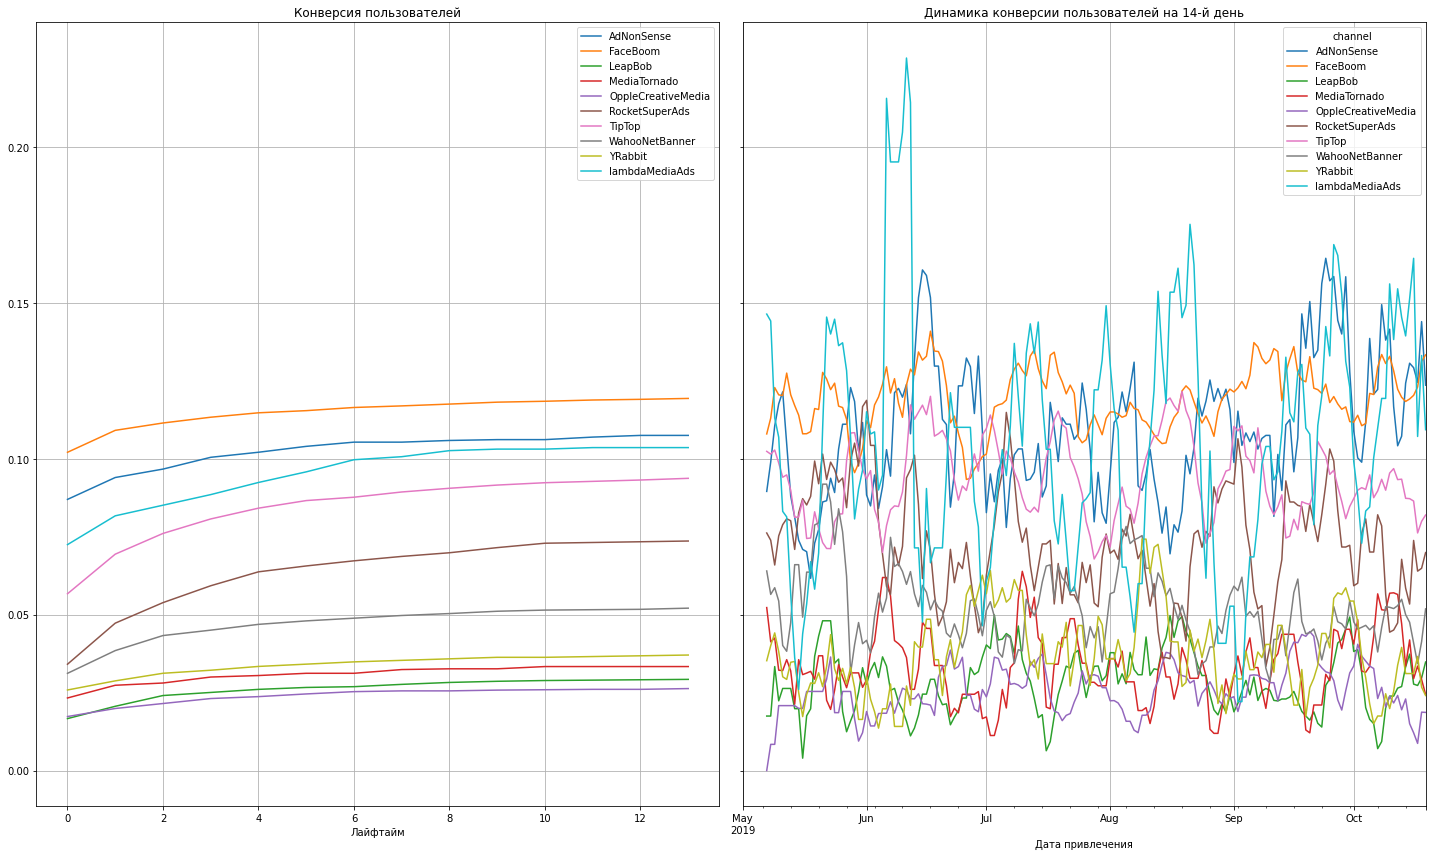

In [33]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия у многих каналов привлечения не очень высокая, и при этом не растет. Но некоторые каналы показывают хорошую конверсию: AdNonSence, FaceBoom, LambdaMediaAds, TipTop.

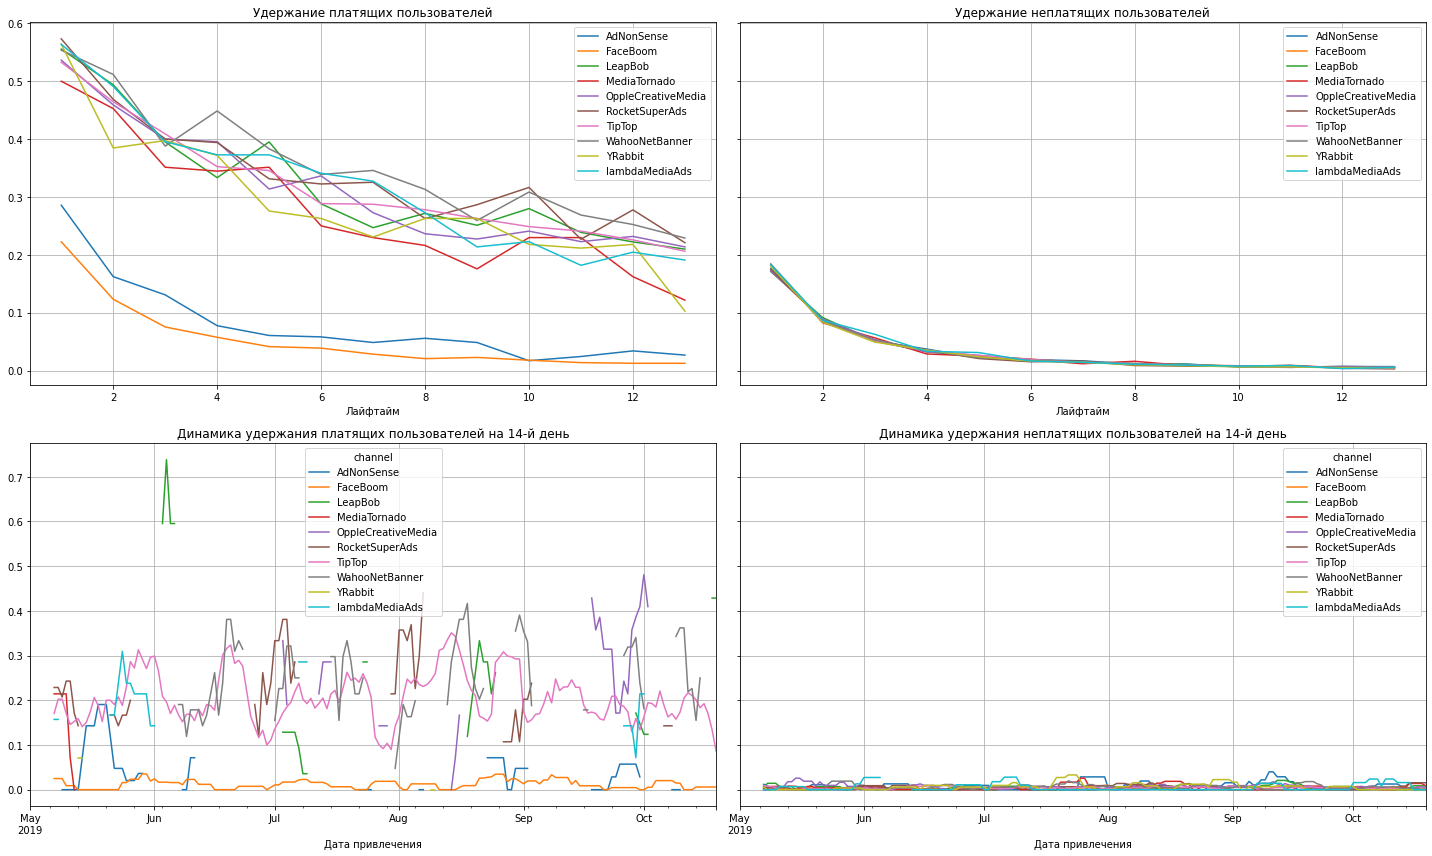

In [34]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей у FaceBoom на крайне низком уровне, почти как без рекламы. Для остальных каналов удержание находится на примерно одинаковом уровне.

## Промежуточные выводы
Пользователи Mac и iPhone конвертируются очень хорошо, с удержанием нет проблем на любой платформе.

Конверсия у пользователей из США сильно выше, чем по другим странам, но удержание заметно ниже. Может быть техническая проблема.

Конверсия у многих каналов привлечения не очень высокая, и при этом не растет. Но некоторые каналы показывают хорошую конверсию: AdNonSence, FaceBoom, LambdaMediaAds, TipTop.
Удержание пользователей у FaceBoom на крайне низком уровне, почти как без рекламы. Для остальных каналов удержание находится на примерно одинаковом уровне.

# Выводы
Причины неэффективности привлечения пользователей:
- Не все каналы привлечения окупаются. Некоторые каналы (TipTop, FaceBoom) приводят много клиентов, которые много платят, но при этом не задерживаются надолго в приложении. Стоит оценить целевую аудиторию этих каналов и сравнить с аудиторией пользователей приложения.
- Пользователи iPhone, Mac и Android не окупают рекламных вложений, хоть пользователи PC и имеют наименьшую конверсию, они единственные окупают вложения. А динамика удержания пользователей на всех платформах одинаковая.
- Пользователей из США больше всех, они ожидаемо обходятся дороже, но при этом, они не приносят прибыли.

Рекомендации для отдела маркетинга:
- Пересмотреть приоритет рекламных каналов, сделать ставку на наиболее прибыльные и удерживаемые, а не на число и конвертацию.
- Следует увеличивать коверсию ПК-юзеров и оптимизировать затраты на остальных устройствах.
- Сконцентрироваться на удержании пользователей из США, их много, они хорошо конвертируются.